# Jeopardy: question patterns
A dataset of Jeopardy questions will be used for this project. The dataset contains 20000 rows (10% of the total) from the beginning of a full dataset of Jeopardy questions. The goal is to figure out if there are any patterns in the questions that could help a contestant win more money.

In [105]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data read-in and clean-up
The first step will be reading in the data. The rows and columns can be then cleaned up or re-formatted where needed.

In [106]:
# Read in the dataset first
jeopardy = pd.read_csv("jeopardy.csv")

In [107]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [108]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [109]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

The column names contain some whitespace, which is easily removed.

In [110]:
columns = []
for i in jeopardy.columns:
    columns.append(i.strip())
jeopardy.columns = columns
jeopardy.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

In [111]:
# Check dataset shape, column types and number of null elements (if any are present).
jeopardy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 7 columns):
Show Number    19999 non-null int64
Air Date       19999 non-null object
Round          19999 non-null object
Category       19999 non-null object
Value          19999 non-null object
Question       19999 non-null object
Answer         19999 non-null object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


Apart from 'Show Number' (containing the episode number), all other columns contain strings. There are a few things to do:
- Normalize the 'Question' and 'Answer' columns by removing uppercase and punctuation. This is necessary because word-search is usually case sensitive.
- Convert 'Values' into integers.
- Convert 'Air Date' into datetime objects.

In [112]:
from re import sub

In [113]:
### NORMALIZE QUESTION AND ANSWER COLUMNS ###
def string_clean(string):
    string = sub(r'[^\w\s]','',string)  # Substitutes all non-alphanumeric, non-whitespace, non-underscore chars with an empty string
    return string.lower()

In [114]:
jeopardy["clean_question"] = jeopardy["Question"].apply(string_clean)
jeopardy["clean_answer"] = jeopardy["Answer"].apply(string_clean)
# Check if everything worked out correctly.
jeopardy[["clean_question","clean_answer"]].head(3)

,clean_question,clean_answer
0,for the last 8 years of his life galileo was u...,copernicus
1,no 2 1912 olympian football star at carlisle i...,jim thorpe
2,the city of yuma in this state has a record av...,arizona


In [115]:
### CONVERT VALUE COLUMN INTO INTEGERS ###
def value_clean(string):
    string = sub(r'[\D]','',string) # Substitutes all non-numerals with an empty string
    try:
        return int(string)
    except:
        return 0

In [116]:
jeopardy["clean_value"] = jeopardy["Value"].apply(value_clean)
# Check if everything worked out correctly.
jeopardy["clean_value"].head(3)

0    200
1    200
2    200
Name: clean_value, dtype: int64

In [117]:
### CONVERT AIR DATE COLUMN INTO DATETIME OBJECTS ###
jeopardy["air_datetime"] = pd.to_datetime(jeopardy["Air Date"])
# Check if everything worked out correctly.
jeopardy["air_datetime"].head(3)

0   2004-12-31
1   2004-12-31
2   2004-12-31
Name: air_datetime, dtype: datetime64[ns]

## Data analysis
### Questions and answers
The first data analysis tasks will revolve around the 'Question' and 'Answer' columns (or rather their cleaned-up versions).
- How often can answers be deduced from the question, i.e. on average, how many words from the question are repeated in the answer? 
- Which words or themes are the most recurrent? 
- Which words or themes are the most valuable in terms of question Value?

### First task
*On average, how many words from the question are repeated in the answer?*

A dedicated function may be used for this.

In [118]:
def shared_words(row):
    split_1 = set(row[7].split(" ")) # Split the string and use set() to remove duplicates
    try:
        split_1.remove("the") # Remove 'the' as this will be repeated often and is not informative
        split_1.remove("") # This can happen where the clean-up left consecutive whitespace
    except:
        pass
    split_2 = set(row[8].split(" ")) # Same as above but for the second string
    try:    
        split_1.remove("the") # Same as above
        split_2.remove("")  # Same as above
    except:
        pass
    shared_words = [x for x in split_1 if x in split_2] # Find shared elements
    return len(shared_words) # Return the number of shared words

In [119]:
jeopardy["shared_words"] = jeopardy.apply(shared_words,axis=1)
# Check that everything worked out correctly.
jeopardy["shared_words"].head(20)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    1
15    0
16    0
17    0
18    0
19    0
Name: shared_words, dtype: int64

Here's a detailed look at question 14:

In [120]:
print(jeopardy.iloc[14,7])

on june 28 1994 the natl weather service began issuing this index that rates the intensity of the suns radiation


In [121]:
print(jeopardy.iloc[14,8])

the uv index


The word "index" is both in the question and the answer so the function seems to have done its job. Furthermore "the" is in both question and answer but wasn't counted. We can now calculate the mean:

In [122]:
jeopardy["shared_words"].mean()

0.143957197859893

On average there are about 0.144 words repeated in the answer per each question. Words are discrete objects of course, so this simply means that one can expect (on average) to find a repeated word about once every seven questions. 

Note that this metric is skewed by answers containing multiple words repeated from the question - a better account can be given by:

In [123]:
def shared_words2(row):
    split_1 = set(row[7].split(" ")) # Split the string and use set() to remove duplicates
    try:
        split_1.remove("the") # Remove 'the' as this will be repeated often and is not informative
        split_1.remove("") # This can happen where the clean-up left consecutive whitespace
    except:
        pass
    split_2 = set(row[8].split(" ")) # Same as above but for the second string
    try:    
        split_1.remove("the") # Same as above
        split_2.remove("")  # Same as above
    except:
        pass
    shared_words = [x for x in split_1 if x in split_2] # Find shared elements
    if len(shared_words) > 0:
        return 1
    else:
        return 0

In [124]:
jeopardy["shared_words2"] = jeopardy.apply(shared_words2,axis=1)
jeopardy["shared_words2"].mean()

0.12650632531626582

Only 12.7% of the answers repeat the questions in some form. This seems to be far too unreliable a factor to grant any help in winning. 

It should also be noted that in general the repetitions do invite an answer, but are also of limited help in and by themselves. The example taken from row 14 shows this, with the question clearly asking for an answer containing an index of some type: however, the contestant would still need to know what UVs are and that there is a specific index for them to answer correctly.

Before moving on, it may be interesting to see how many words are repeated between question and answer limitedly to the question-answer pairs that do display repetitions.

In [125]:
jeopardy_justreps = jeopardy[jeopardy["shared_words"] > 0].copy()
jeopardy_justreps["shared_words"].mean()

1.1379446640316206

When there is indeed a repetition, the results tell that in most cases it is a single-word repetition, further adding to the unreliability of the repetition factor towards gaining a winning edge in the game.

### Second task 
*Which words or themes are the most recurrent?*

The dataset is a selection of only about 10% of the complete one, so this question cannot be answered fully. The problem can still be investigated though, as long as the fact that the dataset is a sample and not a population is kept in mind. These will be the steps:
- Separate and count all words that appear in the questions.
- Filtering the set so that only relevant words are left. This should probably involve a pure list of nouns, since these are the words that usually convey a topic or subject the most. Ideally, the list would contain several thousands of English nouns, including separate singular and plural versions of the words since many nouns in English have irregular plural forms. In practice, this is very difficult to achieve. A good compromise may be [this list](http://www.desiquintans.com/nounlist) of 4554 English nouns (as of 23/08/2018). An alternative approach may be filtering out words which are too common (e.g. words that appear in more than 5% of the questions).

In [126]:
# The number of appearances of each word in the questions are counted here. A dictionary is used because it is a very fast method
# With several thousand words to go through, this is very important
words = {}
def split_unique(x):
    temp = set(x.split(" "))
    return [w for w in temp]
jeopardy["wordsplit"] = jeopardy["clean_question"].apply(split_unique)
for j in range(jeopardy.shape[0]):
    for w in jeopardy.iat[j,13]:
        wdict = {"count": 1}
        if w in words:
            words[w]["count"] += 1
        else:
            words[w] = wdict

In [127]:
# The words are filtered using a list of nouns - this will leave out prepositions, articles etc.
nouns = pd.read_table("nounlist.txt",header=None).loc[:,0].tolist()
filtered_words = {}
for w in words:
    if w in nouns:
        filtered_words[w] = words[w]

In [128]:
# The dictionary is converted into a dataframe for ease of analysis
word_list_df = pd.DataFrame(filtered_words)
word_list_df

,theory,house,life,star,school,football,city,record,year,state,...,gliding,access,astronomy,analog,prose,shack,vitality,percentage,godmother,llama
count,25,160,172,165,115,46,558,61,134,422,...,1,1,1,1,1,1,1,1,1,1


In [129]:
# The dataframe should be transposed
word_list_df = word_list_df.transpose()
word_list_df.head()

,count
theory,25
house,160
life,172
star,165
school,115


Having calculated the number of times each of the words appeared in the list of questions, the word list is ordered by count to produce a set of the most frequent nouns.

Text(0,0.5,'Word')

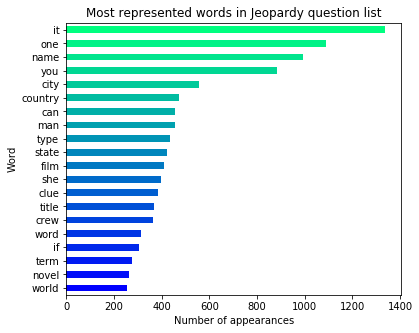

In [130]:
# Order the dataframe by count and select the first 20 words
word_list_df_ordered = word_list_df.sort_values("count", ascending=False)
top_20 = word_list_df_ordered.head(20).sort_values("count", ascending=True) # Re-sort the top 20 so that plot.barh shows the most frequent first
# Visualise the list using a horizontal bar plot
colours = [plt.cm.winter(i) for i in np.linspace(0,1,20)]
fig, ax = plt.subplots(figsize=(6,5))
top_20.plot.barh(y="count",ax=ax,legend=False,color=colours)
ax.set_title("Most represented words in Jeopardy question list")
ax.set_xlabel("Number of appearances")
ax.set_ylabel("Word")

#### Observations
- The noun list apparently included "it" and "if". Their frequency doesn't provide useful information.
- The word "can" appears, but it is very likely that it mostly appears as a verb. It passed the filter in its meaning as a metal container.
- The words "city", "country", "state" all appear in the top 20 list. While "state" has ulterior meaning too (as does "country" to a lesser degree) this indicates that geography may be a good topic to study in preparation for the game.
- The appearance of "film" and "novel" indicates that cinema and literature may be good topics to study as well. The word "title" is present as well and may correlate.
- The appearance of "world" in the list may indicate that world records are often asked about.
- The appearance of "term" and "word" may indicate that rare and/or technical words are often asked about.
- Other words are too generic to identify specific topics and themes to study. Words like "one", "you", "man", "she" provide very little specificity, as do "type", "name" and "clue".

### Third task 
*Which words or themes are the most valuable?*

Having created a list of nouns which appear in the Jeopardy questions, it is also possible to cross-reference the number of appearances with the value of each question. These will be the steps:
- Determine the value of each word as the sum total of the dollar values of all questions which contained the word. The value will be already weighted by the number of occurrences.
- Scale to produce a value score metric for each word in the list.

In [131]:
# The values can be added to the existing 'words' dictionary
# Prepare the dictionary
for w in words:
    words[w]["value"] = 0
# Fill in the word values
for j in range(jeopardy.shape[0]):
    for w in jeopardy.iat[j,13]:
        words[w]["value"] += jeopardy.iat[j,9]

In [132]:
### The following steps are repetition of previous ones - counts and values should have been handled together to begin with
### The analysis is still presented in this fashion to reflect the incremental nature of the procedure
# The words are filtered using a list of nouns - this will leave out prepositions, articles etc.
filtered_words = {}
for w in words:
    if w in nouns:
        filtered_words[w] = words[w]

In [133]:
# The dictionary is converted into a dataframe for ease of analysis
word_list_df = pd.DataFrame(filtered_words)
word_list_df

,theory,house,life,star,school,football,city,record,year,state,...,gliding,access,astronomy,analog,prose,shack,vitality,percentage,godmother,llama
count,25,160,172,165,115,46,558,61,134,422,...,1,1,1,1,1,1,1,1,1,1
value,23200,131500,131100,97500,93700,29800,406800,37500,92900,312900,...,800,1200,1600,200,400,800,400,800,800,100


In [134]:
# The dataframe should be transposed
word_list_df = word_list_df.transpose()
word_list_df.head()

,count,value
theory,25,23200
house,160,131500
life,172,131100
star,165,97500
school,115,93700


In [135]:
# The dollar value is scaled to provide a score metric
word_list_df["value_score"] = word_list_df["value"]/word_list_df["value"].max()

Having calculated the value score of each of the words, the word list is ordered by count to produce a set of the most valuable nouns.

Text(0,0.5,'Word')

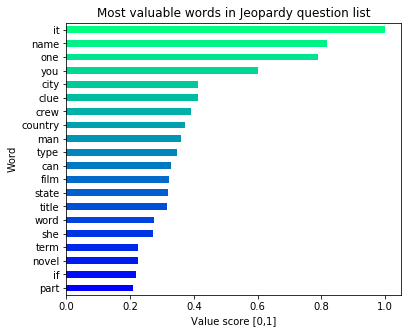

In [136]:
# Order the dataframe by value score and select the first 20 words
word_list_df_ordered_val = word_list_df.sort_values("value_score", ascending=False)
top_20_val = word_list_df_ordered_val.head(20).sort_values("value_score", ascending=True) # Re-sort the top 20 so that plot.barh shows the most frequent first
# Visualise the list using a horizontal bar plot
colours = [plt.cm.winter(i) for i in np.linspace(0,1,20)]
fig, ax = plt.subplots(figsize=(6,5))
top_20_val.plot.barh(y="value_score",ax=ax,legend=False,color=colours)
ax.set_title("Most valuable words in Jeopardy question list")
ax.set_xlabel("Value score [0,1]")
ax.set_ylabel("Word")

## Observations
- The top 20 largely carries over from the top 20 of word appearances. While the average value per question of these words may be lower than others, the sheer amount of questions containing them propels them to the top of the list.
- The word "part" is new, but is quite generic.

# Alternative approach: frequency filter
How would the results for the second and third task change if the noun filter was exchanged for a frequency filter i.e. all words more frequent than a set threshold (e.g. 5% of the questions) were removed?

In [137]:
# The number of appearances and the value of each word are counted here. 
words = {}
def split_unique(x):
    temp = set(x.split(" "))
    return [w for w in temp]
jeopardy["wordsplit"] = jeopardy["clean_question"].apply(split_unique)
for j in range(jeopardy.shape[0]):
    for w in jeopardy.iat[j,13]:
        wdict = {"count": 1, "value": 0}
        if w in words:
            words[w]["count"] += 1
            words[w]["value"] += jeopardy.iat[j,9]
        else:
            words[w] = wdict

In [138]:
# The dictionary is converted into a dataframe for ease of analysis and transposed
word_list_df = pd.DataFrame(filtered_words)
word_list_df = word_list_df.transpose()

In [139]:
# The dataframe is filtered by frequency
word_list_df = word_list_df[word_list_df["count"].between(1,jeopardy.shape[0]*.05)]

Text(0,0.5,'Word')

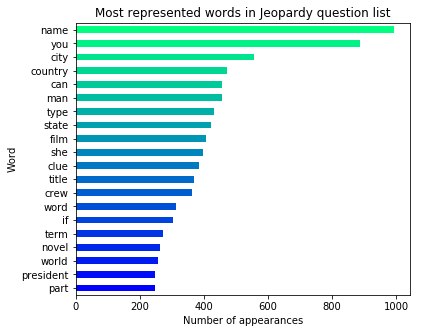

In [141]:
# Order the dataframe by count and select the first 20 words
word_list_df_ordered = word_list_df.sort_values("count", ascending=False)
top_20 = word_list_df_ordered.head(20).sort_values("count", ascending=True) # Re-sort the top 20 so that plot.barh shows the most frequent first
# Visualise the list using a horizontal bar plot
colours = [plt.cm.winter(i) for i in np.linspace(0,1,20)]
fig, ax = plt.subplots(figsize=(6,5))
top_20.plot.barh(y="count",ax=ax,legend=False,color=colours)
ax.set_title("Most represented words in Jeopardy question list")
ax.set_xlabel("Number of appearances")
ax.set_ylabel("Word")

#### Observations
- The top 20 is largely similar to that given by the previous approach, although "president" now appears. US presidents may be a good topic for contestants to study.

In [142]:
# The dollar value is here scaled to provide a score metric
word_list_df["value_score"] = word_list_df["value"]/word_list_df["value"].max()

Text(0,0.5,'Word')

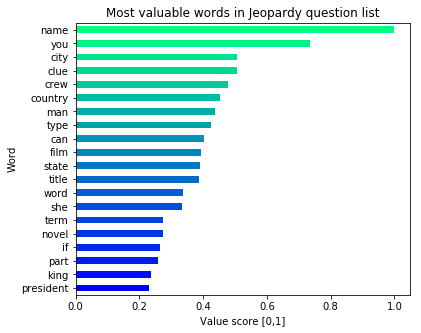

In [144]:
# Order the dataframe by value score and select the first 20 words
word_list_df_ordered_val = word_list_df.sort_values("value_score", ascending=False)
top_20_val = word_list_df_ordered_val.head(20).sort_values("value_score", ascending=True) # Re-sort the top 20 so that plot.barh shows the most frequent first
# Visualise the list using a horizontal bar plot
colours = [plt.cm.winter(i) for i in np.linspace(0,1,20)]
fig, ax = plt.subplots(figsize=(6,5))
top_20_val.plot.barh(y="value_score",ax=ax,legend=False,color=colours)
ax.set_title("Most valuable words in Jeopardy question list")
ax.set_xlabel("Value score [0,1]")
ax.set_ylabel("Word")

#### Observations
- Once again the top 20 largely carries over from the top 20 of word appearances. 
- The word "king" appears as well, so king histories and names may be a good topic to study.